# tl;dr

Cenpy now has the slickest interface of any census data wrangling package out there. Query for what you want, wherever you want, using the placename that you're interested in:

In [2]:
from cenpy import products
import matplotlib.pyplot as plt
%matplotlib inline

/home/serge/anaconda3/envs/cenpy/lib/python3.7/site-packages/fuzzywuzzy-0.17.0-py3.7.egg/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
chicago = products.ACS(2017).from_place('Chicago, IL', level='tract',
                                        variables=['B00002*', 'B01002H_001E'])

Matched: Chicago, IL to Chicago city within layer Incorporated Places


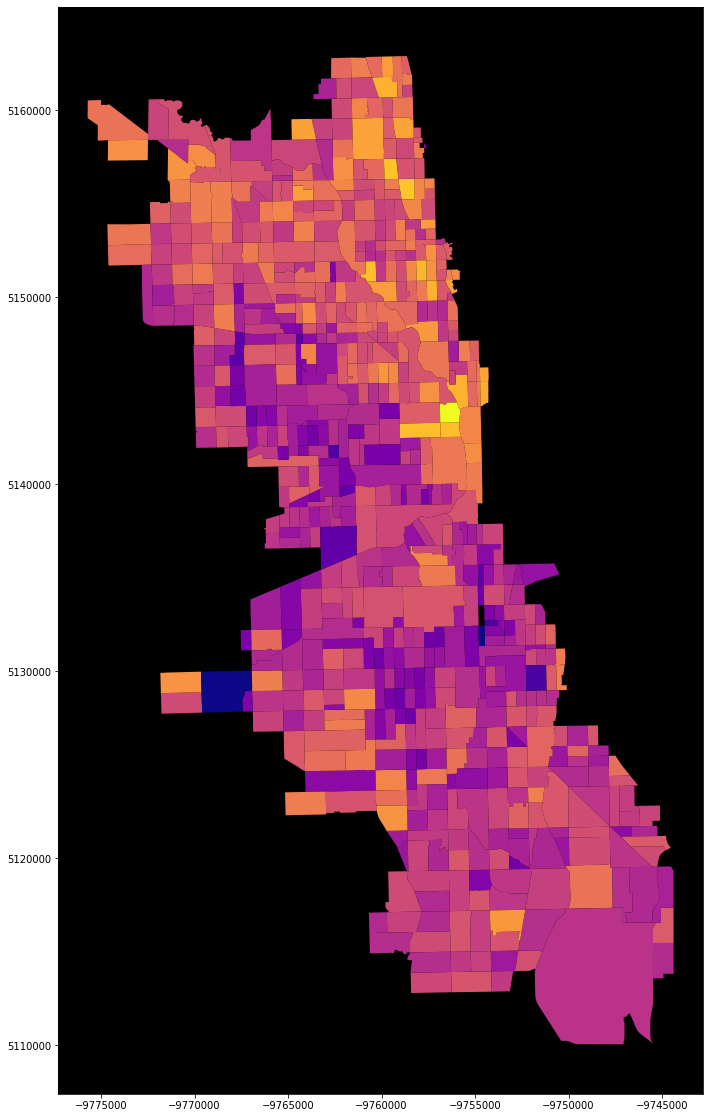

In [4]:
f, ax = plt.subplots(1,1,figsize=(20,20))
chicago.dropna(subset=['B00002_001E'], axis=0).plot('B00002_001E', ax=ax, cmap='plasma')
ax.set_facecolor('k')

In [6]:
detroit_city = products.ACS(2017).from_place('Detroit city', level='tract',
                                             place_type = 'County Subdivision',
                                        variables=['B00002*', 'B01002H_001E'])

Matched: Detroit city to Detroit city within layer County Subdivisions


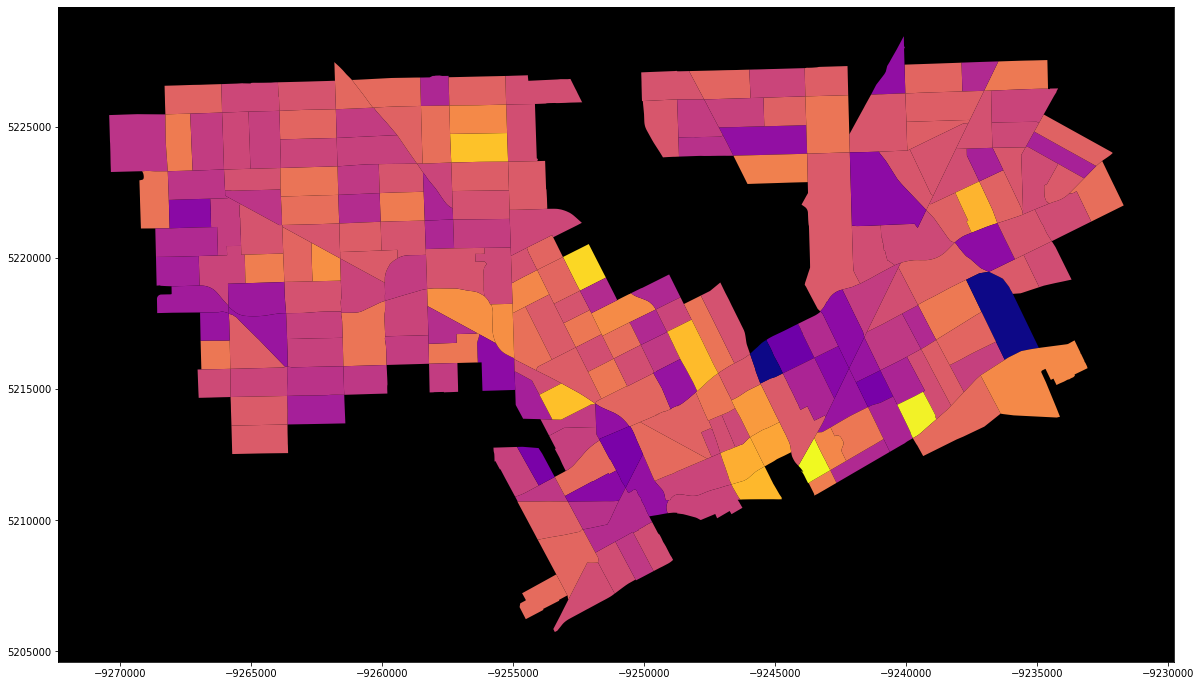

In [7]:
f, ax = plt.subplots(1,1,figsize=(20,20))
detroit_city.dropna(subset=['B00002_001E'], axis=0).plot('B00002_001E', ax=ax, cmap='plasma')
ax.set_facecolor('k')

Install it the prerelease candidate using:

```
pip install --pre cenpy
```

I plan to make a full 1.0 release in July. File bugs, rough edges, things you want me to know about, and interesting behavior at [https://github.com/ljwolf/cenpy](https://github.com/ljwolf/cenpy)! I'll also maintain a roadmap [here](https://github.com/ljwolf/cenpy/milestone/2).

# Cenpy 1.0.0

Cenpy started as an interface to explore and query the US Census API and return Pandas Dataframes. This was mainly intended as a wrapper over the basic functionality provided by the census bureau. I was initially inspired by `acs.R` in its functionality and structure. In addition to `cenpy`, a few other census packages exist out there in the Python ecosystem, such as:

- [datamade/census](https://github.com/datamade/census) - "a python wrapper for the US Census API"
- [jtleider/censusdata](https://github.com/jtleider/censusdata) - "download data from Census API"

And, I've also heard/seen folks use `requests` raw on the Census API to extract the data they want. 

All of the packages I've seen (including `cenpy` itself) involved a very stilted/specific API query due to the way the census API worked. Basically, it's difficult to construct an efficienty query against the census API without knowing the so-called "geographic hierarchy" in which your query fell: 

![The Census Hierarchy](https://ljwolf.org/images/census_hierarchy.png)

The main census API does not allow a user to leave middle levels of the hierarchy vague: For you to get a collection of census tracts in a state, you need to query for all the *counties* in that state, then express your query about tracts in terms of a query about all the tracts in those counties. Even `tidycensus` in `R` [requires this in many common cases](https://walkerke.github.io/tidycensus/articles/basic-usage.html#geography-in-tidycensus). 

Say, to ask for all the blocks in Arizona, you'd need to send a few separate queries:
```
what are the counties in Arizona?
what are the tracts in all of these counties?
what are the blocks in all of these tracts in all of these counties?
```
This was necessary because of the way the hierarchy diagram (shown above) is structured. Blocks don't have a unique identifier outside of their own tract; if you ask for block `001010`, there might be a bunch of blocks around the country that match that identifier. Sometimes, this meant conducting a very large number of repetitive queries, since the packages are trying to build out a correct search tree hierarchy. This style of [tree search](https://en.wikipedia.org/wiki/Breadth-first_search) is relatively slow, especially when conducting this search over the internet...

So, if we focus on the geo-in-geo style queries using the hierarchy above, we're in a tough spot if we want to *also* make the API easy for humans to use. 

# Enter Geographies

Fortunately for us, a *geographic information system* can figure out these kinds of nesting relationships without having to know each of the levels above or below. This lets us use very natural query types, like:
```
what are the blocks *within* Arizona?
```
There is a *geographic information system* that `cenpy` had access to, called the Tiger Web Mapping Service. These are ESRI Mapservices that allow for a fairly complex set of queries to extract information. But, in general, neither [`census`](https://github.com/datamade/census/pull/33) nor `censusdata` used the TIGER web map service API. Cenpy's `cenpy.tiger` was a [fully-featured wrapper around the ESRI Mapservice](https://nbviewer.jupyter.org/gist/dfolch/2440ba28c2ddf5192ad7#5.-Pull-down-the-geometry), but was mainly *not* used by the package itself to solve this tricky problem of building many queries to solve the `geo-in-geo` problem. 

Instead, `cenpy1.0.0` uses the TIGER Web mapping service to intelligently get *all* the required geographies, and then queries for those geographies in a very parsimonious way. This means that, instead of tying our user interface to the census's datastructures, we can have some much more natural place-based query styles. 

# For instance

Let's grab all the tracts in Los Angeles. And, let's get the Race table, `P004`. 

In [ ]:
from cenpy import products
import matplotlib.pyplot as plt
%matplotlib inline

The new `cenpy` API revolves around *products*, which integrate the geographic and the data APIs together. For starters, we'll use the 2010 Decennial API: 

In [ ]:
dectest = products.Decennial2010()

Now, since we don't need to worry about entering geo-in-geo structures for our queries, we can request Race data for all the tracts in Los Angeles County using the following method:

In [ ]:
la = dectest.from_county('Los Angeles, CA', 
                          level='tract', 
                          variables=['^P004'])

And, making a pretty plot of the Hispanic population in LA:

In [ ]:
f,ax = plt.subplots(1,1,figsize=(20,20))
la.plot('P004003', edgecolor='white', cmap='plasma', ax=ax, linewidth=.2)
ax.set_facecolor('k')

How this *works* from a software perspective is a significant imporvement on how the other packages, like `cenpy` itself, work.
1. Take the name the user provided and find a match `target` within a level of the census geography. *(e.g. match Los Angeles, CA to Los Angeles County)*
2. **Using the Web Mapping Service,** find all the tracts that fall within our `target`.
3. **Using the data API,** query for all the data about those tracts that are requested.

Since the Web Mapping Service provides us all the information needed to build a complete geo-in-geo query, we don't need to use repeated queries. Further, since we are using *spatial querying* to do the heavy lifting, there's no need for the user to specify a detailed geo-in-geo hierarchy: using the [Census GIS](https://tigerweb.geo.census.gov/tigerwebmain/tigerweb_restmapservice.html), we can build the hierarchy for free. 

Thus, this even works for grabbing `block` information over a very large area, such as the Austin, TX MSA:

In [ ]:
aus = dectest.from_msa('Austin, TX', level='block', variables=['^P003', 'P001001'])

In [ ]:
f,ax = plt.subplots(1,1,figsize=(20,20))
aus.plot('P003003',cmap='plasma', linewidth=0, ax=ax)
ax.set_facecolor('k')

Or, for example, a case that's difficult to deal with: census geographies that span two states. Let's just grab all the tracts in the Kansas City consolidated statistical area, regardless of which state they fall into:

In [ ]:
ks = dectest.from_csa('Kansas City', level='tract', variables=['P001001'])

In [ ]:
f,ax = plt.subplots(1,1,figsize=(20,20))
ks.plot('P001001', ax=ax, cmap='plasma', linewidth=0)
ax.set_facecolor('k')

## A bit of the weeds

Thus, now `cenpy` has a very simple interface to grab just the data you want and get out of your way. But, there are a few additional helper functions to make it simple to work with data. 

For instance, it's possible to extract the boundary of the *target* boundary using the `return_bounds` argument:

In [ ]:
ma, ma_bounds = dectest.from_state('Massachusetts', 
                                   return_bounds=True)

In [ ]:
f, ax = plt.subplots(1,1,figsize=(20,20))
ma.plot(edgecolor='slategrey', color='none', ax=ax)
ma_bounds.plot(edgecolor='cornsilk', color='none', ax=ax, linewidth=2)
ax.set_facecolor('k')

And, because some kinds of census geometries do not nest neatly within one another, it's possible to request that the "within" part of the geo-in-geo operation is relaxed to only consider geometries that *intersect* with the requested place:

In [ ]:
tuc, tuc_bounds = dectest.from_place('Tucson, AZ', 
                                     level='tract',
                                     return_bounds=True, 
                                     strict_within=False)

In [ ]:
f, ax = plt.subplots(1,1,figsize=(20,20))
tuc.plot(edgecolor='slategrey', color='none', ax=ax)
tuc_bounds.plot(edgecolor='cornsilk', color='none', ax=ax, linewidth=2)
ax.set_facecolor('k')

# Additional Products

This works for all of the ACSs that are supported by the Web Mapping Service. This means that `cenpy` supports this place-based API for the results from 2013 to 2017:

In [ ]:
for year in range(2013, 2018):
    products.ACS(year=year).from_place('Tucson, AZ')

And it has the same general structure as we saw before:

In [ ]:
sf = products.ACS(2017).from_place('San Francisco, CA', level='tract',
                                   variables=['B00002*', 'B01002H_001E'])

In [ ]:
f,ax = plt.subplots(1,1,figsize=(20,20))
ax = sf.dropna(subset=['B00002_001E']).plot('B00002_001E', cmap='plasma', linewidth=0, ax=ax)
ax.set_facecolor('k')

# Happy hacking!

To install this version of cenpy, grab the *release candidate*:

```
pip install --pre cenpy
```

I plan to create a full release at SciPy2018, in early July. File bugs, rough edges, things you want me to know about, and interesting behavior at [https://github.com/ljwolf/cenpy](https://github.com/ljwolf/cenpy)!